<a href="https://colab.research.google.com/github/Engineer-Ayesha-Shafique/Devil-s-Tone-Text-to-Music-generator/blob/main/Devil's_Tone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Devil's Tone

***

## Text to music generator

***


# Setup environment

In [ ]:
#@title Install dependencies
!git clone https://github.com/asigalov61/tegridy-tools
!pip install tqdm

# for data
!pip install fuzzywuzzy[speedup]

# for listening
!apt install fluidsynth #Pip does not work for some reason. Only apt works
!pip install midi2audio

# packages below are for plotting pianoroll only
# they are not needed for anything else
!pip install pretty_midi
!pip install librosa
!pip install matplotlib

Cloning into 'tegridy-tools'...
remote: Enumerating objects: 2707, done.
remote: Counting objects: 100% (261/261), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 2707 (delta 146), reused 177 (delta 97), pack-reused 2446
Receiving objects: 100% (2707/2707), 139.59 MiB | 20.32 MiB/s, done.
Resolving deltas: 100% (1734/1734), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 22.4 MB/s 
     |████████████████████████████████| 2.2 MB 80.9 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11ex

In [ ]:
#@title Load needed modules
print('Loading needed modules. Please wait...')

import sys
import os
import json
import secrets
import copy

os.chdir('/content/tegridy-tools/tegridy-tools/')
import TMIDI
os.chdir('/content/')

from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from itertools import islice, accumulate

from pprint import pprint

import tqdm.auto
from tqdm import auto
from midi2audio import FluidSynth
from IPython.display import display, Javascript, HTML, Audio

# only for plotting pianoroll
import pretty_midi
import librosa.display
import matplotlib.pyplot as plt

from google.colab import output, drive

print('Creating Dataset dir...')
if not os.path.exists('/content/Dataset'):
    os.makedirs('/content/Dataset')

os.chdir('/content/')
print('Loading complete. Enjoy! :)')

Loading needed modules. Please wait...
Creating Dataset dir...
Loading complete. Enjoy! :)


# Prep statistics dictionary

In [ ]:
#@title Download English Karaoke MIDI classification model
%cd /content/
!wget --no-check-certificate -O Karaoke-English-Full.pickle "https://onedrive.live.com/download?cid=8A0D502FC99C608F&resid=8A0D502FC99C608F%2118485&authkey=ABXca9Cn2L-64UE"

/content
--2022-12-20 05:33:11--  https://onedrive.live.com/download?cid=8A0D502FC99C608F&resid=8A0D502FC99C608F%2118485&authkey=ABXca9Cn2L-64UE
Resolving onedrive.live.com (onedrive.live.com)... 13.107.42.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.42.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://wz1z3g.dm.files.1drv.com/y4m5wc0gJEe7al4SMvt9ifYFMNAbe4rhvAimmhxIYel2IeFidvwqA7qQc1BGVKc93ay6oJvH_KU1E7xUGpzFuEmsEmW0hVhkfMQrreCtnZpHyhqIBDMKoboAWIf7Npf1SquGvd40K4kGh8y_kt0igdKLC9_B197QI1feZA90qsA_AZrxdYzTxUsCX2vmcxqwostzxcNDYvyv_ONzjw_AqK2Zg/Karaoke-English-Full.pickle?download&psid=1 [following]
--2022-12-20 05:33:12--  https://wz1z3g.dm.files.1drv.com/y4m5wc0gJEe7al4SMvt9ifYFMNAbe4rhvAimmhxIYel2IeFidvwqA7qQc1BGVKc93ay6oJvH_KU1E7xUGpzFuEmsEmW0hVhkfMQrreCtnZpHyhqIBDMKoboAWIf7Npf1SquGvd40K4kGh8y_kt0igdKLC9_B197QI1feZA90qsA_AZrxdYzTxUsCX2vmcxqwostzxcNDYvyv_ONzjw_AqK2Zg/Karaoke-English-Full.pickle?download&psid=1
Resolving wz1z3g.dm.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Load and prep the model

print('Loading the Karaoke model. Please wait...')
data = TMIDI.Tegridy_Any_Pickle_File_Loader('/content/Karaoke-English-Full')

print('Done!')
print('Prepping data...')

kar_ev_f = data[2]

kar = []
karaoke = []

for k in auto.tqdm(kar_ev_f):
  k.sort(reverse=False, key=lambda x: x[1])
#  print(k)
  for kk in k:
    if kk[0] == 'note' or kk[0] == 'text_event':
      kar.append(kk)

kar_words = []
for o in auto.tqdm(kar):
  if o[0] != 'note':
    kar_words.append(str(o[2]).lower())
    #print(str(o[2]).lower())
print('Done! Enjoy! :)')

Loading the Karaoke model. Please wait...
Tegridy Pickle File Loader
Loading the pickle file. Please wait...
Done!
Prepping data...


  0%|          | 0/2374 [00:00<?, ?it/s]

  0%|          | 0/8719318 [00:00<?, ?it/s]

Done! Enjoy! :)


# Generate Music



In [ ]:
#@title Generate Music from the lyrics below

#@markdown NOTE: No symbols, special chars, commas, etc., please.

#@markdown ProTip: Be as ambiguous and general as possible for best results as the current dictionary is too small for anything specific.

randomize_words_matching = False #@param {type:"boolean"}

lyric1 = 'I love you very very much' #@param {type:"string"}
lyric2 = 'I can not live without you' #@param {type:"string"}
lyric3 = 'You always present on my mind' #@param {type:"string"}
lyric4 = 'I often think about you' #@param {type:"string"}

lyric5 = 'I am all out of love I am so lost without you' #@param {type:"string"}
lyric6 = 'I know you were right believing for so long' #@param {type:"string"}
lyric7 = 'I am all out of love what am I without you' #@param {type:"string"}
lyric8 = 'I cant be too late to say that I was so wrong' #@param {type:"string"}

text = [lyric1, lyric2, lyric3, lyric4, lyric5, lyric6, lyric7, lyric8]

song = []

words_lst = ''

print('=' * 100)

print('Devilz Tone Text to Music Generator')
print('Starting up...')

print('=' * 100)

for t in auto.tqdm(text):
  txt = t.lower().split(' ')

  kar_words_split = list(TMIDI.Tegridy_List_Slicer(kar_words, len(txt)))
#  print(kar_words_split)
  ratings = []
  for k in kar_words_split:
    ratings.append(fuzz.ratio(txt, k))
  if randomize_words_matching:
    try:
      ind = ratings.index(secrets.choice([max(ratings)-5, max(ratings)-4, max(ratings)-3, max(ratings)-2, max(ratings)-1, max(ratings)]))
    except:
      ind = ratings.index(max(ratings))

  else:
    ind = ratings.index(max(ratings))

  words_list = kar_words_split[ind]
  pos = ind * len(txt)

  print(words_list)

  words_lst += ' '.join(words_list) + chr(10)

  c = 0
  for i in range(len(kar)):
    if kar[i][0] != 'note':
      if c == pos:
        idx = i
        break
    if kar[i][0] != 'note':
      c += 1

  c = 0
#   print(idx)
#   print(len(kar))

  for i in range(idx, len(kar)):
    # print(kar[i])
    # print(kar[i][0])
    if kar[i][0] != 'note':
      if c == len(txt):
        break
    if kar[i][0] == 'note':
      song.append(kar[i])
    if kar[i][0] != 'note':
      c += 1
      song.append(kar[i])

so = [y for y in song if len(y) > 3]
if so != []: sigs = TMIDI.Tegridy_MIDI_Signature(so, so)

print('=' * 100)

print(sigs[0])

print('=' * 100)

song1 = []
p = song[0]
p[1] = 0
time = 0

song.sort(reverse=False, key=lambda x: x[1])

for i in range(len(song)-1):
    ss = copy.deepcopy(song[i])
    if song[i][1] != p[1]:

      if abs(song[i][1] - p[1]) > 1000:
        time += 300
      else:
        time += abs(song[i][1] - p[1])

      ss[1] = time
      song1.append(ss)

      p = copy.deepcopy(song[i])
    else:

      ss[1] = time
      song1.append(ss)

      p = copy.deepcopy(song[i])

pprint(words_lst, compact=True)
print('=' * 100)

Devilz Tone Text to Music Generator
Starting up...


  0%|          | 0/8 [00:00<?, ?it/s]

['i', 'love', 'you', 'e', 'ven', 'more']
['i', 'am', 'in', 'love', 'with', 'you']
['go', 'al', 'ways', 'on', 'my', 'mind,']
['i', 'feel', 'a', 'bout', 'you']
["i'm", 'all', 'out', 'of', 'love', "i'm", 'so', 'lost', 'with', 'out', 'you', 'i']
['know', 'you', 'were', 'right', 'belie', 'ving', 'for', 'so', 'long']
['long', "i'm", 'all', 'out', 'of', 'love', 'what', 'am', 'i', 'wit', 'hout']
["can't", 'be', 'too', 'late', 'to', 'say', 'that', 'i', 'was', 'so', 'wrong', "i'mall"]
[102076743, 139069, 518605, 706, 2753, 3, 46528, 63, 61021, 83]
('i love you e ven more\n'
 'i am in love with you\n'
 'go al ways on my mind,\n'
 'i feel a bout you\n'
 "i'm all out of love i'm so lost with out you i\n"
 'know you were right belie ving for so long\n'
 "long i'm all out of love what am i wit hout\n"
 "can't be too late to say that i was so wrong i'mall\n")


# Convert generated music composition to MIDI file and download/listen to the output :)

In [ ]:
#@title Convert to MIDI

TMIDI.Tegridy_SONG_to_MIDI_Converter(song1, output_file_name='/content/devilz-tone-Output-MIDI')
!zip -r /content/devilz-tone-Output-MIDI.zip /content/devilz-tone-Output-MIDI

Converting to MIDI. Please stand-by...
Done! Enjoy! :)
	zip warning: name not matched: /content/devilz-tone-Output-MIDI

zip error: Nothing to do! (try: zip -r /content/devilz-tone-Output-MIDI.zip . -i /content/devilz-tone-Output-MIDI)


# New Section

Playing and plotting composition...
Synthesizing the last output MIDI. Please stand-by... 


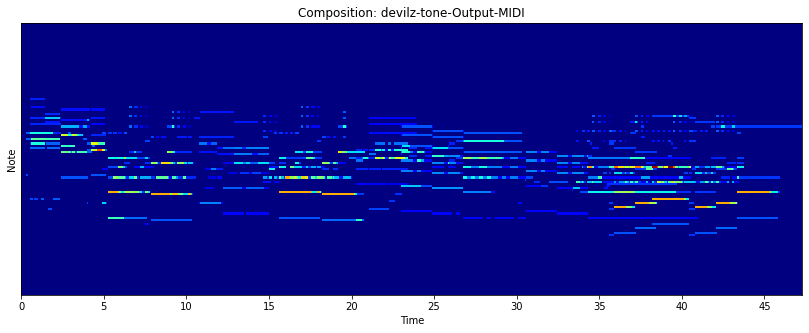

In [ ]:
#@title Plot and listen to the last generated composition
####@markdown NOTE: May be very slow with the long compositions
fname = '/content/devilz-tone-Output-MIDI'

fn = os.path.basename(fname + '.mid')
fn1 = fn.split('.')[0]
# print(fn1)
print('Playing and plotting composition...')
pm = pretty_midi.PrettyMIDI(fname + '.mid')
# Retrieve piano roll of the MIDI file
piano_roll = pm.get_piano_roll()

plt.figure(figsize=(14, 5))
librosa.display.specshow(piano_roll, x_axis='time', y_axis='cqt_note', fmin=1, hop_length=160, sr=16000, cmap=plt.cm.jet)
plt.title('Composition: ' + fn1)


print('Synthesizing the last output MIDI. Please stand-by... ')
FluidSynth("/usr/share/sounds/sf2/FluidR3_GM.sf2", 16000).midi_to_audio(str(fname + '.mid'), str(fname + '.wav'))
Audio(str(fname + '.wav'), rate=16000)

# Congrats! You did it! :)